In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline as Pipeline
from imblearn.pipeline import Pipeline as Pipelinesm
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold
from sklearn.metrics import mean_absolute_error
from imblearn.over_sampling import SMOTE

from catboost import CatBoostClassifier
from sklearn.linear_model import Lasso

In [3]:
### Default settings for matplotlib

import matplotlib as mlp
import seaborn as sns

mlp.rcParams['lines.linewidth'] = 2
mlp.rcParams['xtick.major.size'] = 10
mlp.rcParams['xtick.major.width'] = 3
mlp.rcParams['xtick.labelsize'] = 10
mlp.rcParams['xtick.color'] = '#FF5533'

mlp.rcParams['ytick.major.size'] = 10
mlp.rcParams['ytick.major.width'] = 3
mlp.rcParams['ytick.labelsize'] = 10
mlp.rcParams['ytick.color'] = '#FF5533'

mlp.rcParams['axes.labelsize'] = 15
mlp.rcParams['axes.titlesize'] = 15

<h2> Data Extraction and Analysis </h2>

In [4]:
# Function to extract sheet from xls

def extract_sheets(file_path, start, end):
    # Load the Excel file
    xls = pd.ExcelFile(file_path)
    # Extract the sheet names
    sheet_names = xls.sheet_names
    # Extract the specified range of sheets
    dfs = [pd.read_excel(xls, sheet_name=sheet) for sheet in sheet_names[start:end]]
    
    return dfs

path = "Marketing_Optimization_Dataset.xlsx"
start_idx = 1  
end_idx = 5    

# Extract the specified sheets
df1, df2, df3, df4 = extract_sheets(path, start_idx, end_idx)

<medium> **Data wrangling - df1** </medium>

Checking columns values, types, and NA values. Filling NA values.

In [5]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1615 entries, 0 to 1614
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Client  1615 non-null   int64 
 1   Sex     1612 non-null   object
 2   Age     1615 non-null   int64 
 3   Tenure  1615 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 50.6+ KB


In [6]:
df1.head()

,Client,Sex,Age,Tenure
0,909,M,21,27
1,1217,M,38,165
2,850,F,49,44
3,1473,M,54,34
4,1038,M,29,106


In [7]:
df1.isna().sum()

Client    0
Sex       3
Age       0
Tenure    0
dtype: int64

In [8]:
# Filling NA in Sex column with the most popular value

most_popular_count = df1.Sex.value_counts().idxmax()
df1.fillna({'Sex': most_popular_count}, inplace = True)
df1.isna().sum()

Client    0
Sex       0
Age       0
Tenure    0
dtype: int64

In [9]:
# Encoding the Sex column

df1['Sex'] = [1 if val == 'M' else 0 for val in df1['Sex']]

<medium> **Data wrangling - df2** </medium>

Checking columns values, types, and NA values. Filling NA values.

In [10]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1615 entries, 0 to 1614
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Client      1615 non-null   int64  
 1   Count_CA    1615 non-null   int64  
 2   Count_SA    426 non-null    float64
 3   Count_MF    306 non-null    float64
 4   Count_OVD   419 non-null    float64
 5   Count_CC    170 non-null    float64
 6   Count_CL    135 non-null    float64
 7   ActBal_CA   1615 non-null   float64
 8   ActBal_SA   426 non-null    float64
 9   ActBal_MF   306 non-null    float64
 10  ActBal_OVD  419 non-null    float64
 11  ActBal_CC   170 non-null    float64
 12  ActBal_CL   135 non-null    float64
dtypes: float64(11), int64(2)
memory usage: 164.1 KB


In [11]:
df2.head()

,Client,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,ActBal_SA,ActBal_MF,ActBal_OVD,ActBal_CC,ActBal_CL
0,1,1,NaN,NaN,1.0,NaN,NaN,1333.802857,NaN,NaN,0.0,NaN,NaN
1,2,1,1.0,NaN,NaN,NaN,NaN,110.768571,13326.190357,NaN,NaN,NaN,NaN
2,3,1,NaN,1.0,NaN,NaN,NaN,482.654643,NaN,107.251786,NaN,NaN,NaN
3,4,1,1.0,NaN,NaN,1.0,NaN,1599.840714,76.437143,NaN,NaN,1110.381786,NaN
4,5,1,1.0,NaN,NaN,NaN,NaN,5353.483929,8079.715714,NaN,NaN,NaN,NaN


In [12]:
df2.isna().sum()

Client           0
Count_CA         0
Count_SA      1189
Count_MF      1309
Count_OVD     1196
Count_CC      1445
Count_CL      1480
ActBal_CA        0
ActBal_SA     1189
ActBal_MF     1309
ActBal_OVD    1196
ActBal_CC     1445
ActBal_CL     1480
dtype: int64

<medium>  **Assumption 1**. If the mentionned columns contain NA values, then they should be zeros. Otherwise, should have been mentioned in the bank system and in dataset. Therefore, imputing NA values with zeros. </medium>

In [13]:
df2 = df2.fillna(0)

<medium> **Data wrangling - df3** </medium>

Checking columns values, types, and NA values. Investigating correlations between variables, filtering out highly correlated columns. 

In [14]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1587 entries, 0 to 1586
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Client                        1587 non-null   int64  
 1   VolumeCred                    1587 non-null   float64
 2   VolumeCred_CA                 1587 non-null   float64
 3   TransactionsCred              1587 non-null   int64  
 4   TransactionsCred_CA           1587 non-null   int64  
 5   VolumeDeb                     1587 non-null   float64
 6   VolumeDeb_CA                  1587 non-null   float64
 7   VolumeDebCash_Card            1587 non-null   float64
 8   VolumeDebCashless_Card        1587 non-null   float64
 9   VolumeDeb_PaymentOrder        1587 non-null   float64
 10  TransactionsDeb               1587 non-null   int64  
 11  TransactionsDeb_CA            1587 non-null   int64  
 12  TransactionsDebCash_Card      1587 non-null   int64  
 13  Tra

In [15]:
df3.isna().sum()

Client                          0
VolumeCred                      0
VolumeCred_CA                   0
TransactionsCred                0
TransactionsCred_CA             0
VolumeDeb                       0
VolumeDeb_CA                    0
VolumeDebCash_Card              0
VolumeDebCashless_Card          0
VolumeDeb_PaymentOrder          0
TransactionsDeb                 0
TransactionsDeb_CA              0
TransactionsDebCash_Card        0
TransactionsDebCashless_Card    0
TransactionsDeb_PaymentOrder    0
dtype: int64

In [16]:
df3.info()
df3_numeric_columns = df3.columns.drop('Client')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1587 entries, 0 to 1586
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Client                        1587 non-null   int64  
 1   VolumeCred                    1587 non-null   float64
 2   VolumeCred_CA                 1587 non-null   float64
 3   TransactionsCred              1587 non-null   int64  
 4   TransactionsCred_CA           1587 non-null   int64  
 5   VolumeDeb                     1587 non-null   float64
 6   VolumeDeb_CA                  1587 non-null   float64
 7   VolumeDebCash_Card            1587 non-null   float64
 8   VolumeDebCashless_Card        1587 non-null   float64
 9   VolumeDeb_PaymentOrder        1587 non-null   float64
 10  TransactionsDeb               1587 non-null   int64  
 11  TransactionsDeb_CA            1587 non-null   int64  
 12  TransactionsDebCash_Card      1587 non-null   int64  
 13  Tra

In [17]:
### Functions to show top correlations

def get_redundant_pairs(df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, cor_type='pearson', n=5):
    au_corr = df.corr(cor_type).abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(df3[df3_numeric_columns], n=10))

Top Absolute Correlations
TransactionsCred  TransactionsCred_CA             0.947662
VolumeDeb         VolumeDeb_CA                    0.944994
VolumeCred        VolumeCred_CA                   0.937090
TransactionsDeb   TransactionsDeb_CA              0.918128
VolumeCred        VolumeDeb_CA                    0.867303
                  VolumeDeb                       0.853392
VolumeDeb_CA      VolumeDeb_PaymentOrder          0.838541
VolumeDeb         VolumeDeb_PaymentOrder          0.829853
VolumeCred_CA     VolumeDeb_CA                    0.822232
TransactionsDeb   TransactionsDebCashless_Card    0.800941
dtype: float64


<medium> Column_X_CA is a subset of column Column_X.\
**Assumption 2**: Keeping only Column_X will not lead to substantial information loss.
    
Columns VolumeDeb and TransactionsDeb are almost fully represented by their individual components.\
**Assumption 3**: Choosing the sum columns VolumeDeb and TransactionsDeb instead of their individual components. </medium>

In [18]:
df3_numeric_columns = df3_numeric_columns.drop(['VolumeCred_CA', 'TransactionsCred_CA', 'VolumeDeb_CA', 'TransactionsDeb_CA',
                'VolumeDeb','TransactionsDeb'])

df3 = df3.drop(['VolumeCred_CA', 'TransactionsCred_CA', 'VolumeDeb_CA', 'TransactionsDeb_CA',
                'VolumeDeb','TransactionsDeb'], axis=1)

In [19]:
print("Top Absolute Correlations, Pearson")
print(get_top_abs_correlations(df3[df3_numeric_columns], n=10))

Top Absolute Correlations, Pearson
VolumeDebCashless_Card        TransactionsDebCashless_Card    0.703199
VolumeCred                    VolumeDeb_PaymentOrder          0.661139
TransactionsCred              TransactionsDeb_PaymentOrder    0.447120
VolumeCred                    VolumeDebCash_Card              0.402719
TransactionsDebCash_Card      TransactionsDebCashless_Card    0.367573
TransactionsDebCashless_Card  TransactionsDeb_PaymentOrder    0.367440
VolumeDebCashless_Card        TransactionsDeb_PaymentOrder    0.355057
VolumeDebCash_Card            TransactionsDebCash_Card        0.348973
VolumeCred                    TransactionsDeb_PaymentOrder    0.316406
TransactionsCred              TransactionsDebCashless_Card    0.314382
dtype: float64


In [20]:
print("Top Absolute Correlations, Kendall")
print(get_top_abs_correlations(df3[df3_numeric_columns], 'kendall',10))

Top Absolute Correlations, Kendall
VolumeDebCashless_Card    TransactionsDebCashless_Card    0.842503
VolumeDeb_PaymentOrder    TransactionsDeb_PaymentOrder    0.746361
VolumeDebCash_Card        TransactionsDebCash_Card        0.726845
VolumeCred                TransactionsCred                0.535291
                          VolumeDeb_PaymentOrder          0.520224
                          TransactionsDeb_PaymentOrder    0.488733
TransactionsCred          TransactionsDeb_PaymentOrder    0.426152
TransactionsDebCash_Card  TransactionsDebCashless_Card    0.397352
TransactionsCred          VolumeDeb_PaymentOrder          0.389859
VolumeCred                VolumeDebCashless_Card          0.348522
dtype: float64


In [21]:
print("Top Absolute Correlations, Spearman")
print(get_top_abs_correlations(df3[df3_numeric_columns], 'spearman',10))

Top Absolute Correlations, Spearman
VolumeDebCashless_Card    TransactionsDebCashless_Card    0.954598
VolumeDeb_PaymentOrder    TransactionsDeb_PaymentOrder    0.885652
VolumeDebCash_Card        TransactionsDebCash_Card        0.872235
VolumeCred                TransactionsCred                0.693586
                          VolumeDeb_PaymentOrder          0.681972
                          TransactionsDeb_PaymentOrder    0.646763
TransactionsCred          TransactionsDeb_PaymentOrder    0.552910
                          VolumeDeb_PaymentOrder          0.520337
TransactionsDebCash_Card  TransactionsDebCashless_Card    0.492675
VolumeCred                VolumeDebCashless_Card          0.467160
dtype: float64


<medium> **Data wrangling - df4** </medium>

In [22]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 969 entries, 0 to 968
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Client      969 non-null    int64  
 1   Sale_MF     969 non-null    int64  
 2   Sale_CC     969 non-null    int64  
 3   Sale_CL     969 non-null    int64  
 4   Revenue_MF  969 non-null    float64
 5   Revenue_CC  969 non-null    float64
 6   Revenue_CL  969 non-null    float64
dtypes: float64(3), int64(4)
memory usage: 53.1 KB


In [23]:
df4.head()

,Client,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
0,1094,0,1,0,0.000000,5.138571,0.0000
1,1484,1,0,1,25.609107,0.000000,8.7225
2,20,0,1,0,0.000000,3.822500,0.0000
3,1193,0,0,0,0.000000,0.000000,0.0000
4,142,0,0,0,0.000000,0.000000,0.0000


In [24]:
df4.isna().sum()

Client        0
Sale_MF       0
Sale_CC       0
Sale_CL       0
Revenue_MF    0
Revenue_CC    0
Revenue_CL    0
dtype: int64

In [25]:
# Creating merged training dataset

df_merged = pd.merge(df4, df3, on='Client', how='left')
df_merged = pd.merge(df_merged, df2, on='Client', how='left')
df_merged = pd.merge(df_merged, df1, on='Client', how='left')

In [26]:
df_merged.head()

,Client,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL,VolumeCred,TransactionsCred,VolumeDebCash_Card,...,Count_CL,ActBal_CA,ActBal_SA,ActBal_MF,ActBal_OVD,ActBal_CC,ActBal_CL,Sex,Age,Tenure
0,1094,0,1,0,0.000000,5.138571,0.0000,0.011786,1.0,53.571429,...,0.0,89.022500,0.0000,0.0,0.0,0.0,0.0,1,25,8
1,1484,1,0,1,25.609107,0.000000,8.7225,1355.088571,5.0,107.142857,...,0.0,0.000000,0.0000,0.0,0.0,0.0,0.0,1,39,0
2,20,0,1,0,0.000000,3.822500,0.0000,452.617500,4.0,107.142857,...,0.0,2194.472143,18302.0625,0.0,0.0,0.0,0.0,1,27,181
3,1193,0,0,0,0.000000,0.000000,0.0000,1442.837857,23.0,507.142857,...,0.0,4180.697500,0.0000,0.0,0.0,0.0,0.0,1,48,16
4,142,0,0,0,0.000000,0.000000,0.0000,714.285714,1.0,0.000000,...,0.0,1511.683929,0.0000,0.0,0.0,0.0,0.0,0,27,183


In [27]:
df_merged.isna().sum()

Client                           0
Sale_MF                          0
Sale_CC                          0
Sale_CL                          0
Revenue_MF                       0
Revenue_CC                       0
Revenue_CL                       0
VolumeCred                      18
TransactionsCred                18
VolumeDebCash_Card              18
VolumeDebCashless_Card          18
VolumeDeb_PaymentOrder          18
TransactionsDebCash_Card        18
TransactionsDebCashless_Card    18
TransactionsDeb_PaymentOrder    18
Count_CA                         0
Count_SA                         0
Count_MF                         0
Count_OVD                        0
Count_CC                         0
Count_CL                         0
ActBal_CA                        0
ActBal_SA                        0
ActBal_MF                        0
ActBal_OVD                       0
ActBal_CC                        0
ActBal_CL                        0
Sex                              0
Age                 

In [28]:
# Dropping NA

columns_with_na = df_merged.columns[df_merged.isna().any()].tolist()

df_merged = df_merged.dropna()
df_merged.shape

(951, 30)

<medium> **Sanity check for the merged dataframe** </medium>

- A person must be older than 10 years to open a current account or any of the mentioned products.
- There should be no discrepancy with person's Age and Tenure in the bank.

In [29]:
df_merged.columns

Index(['Client', 'Sale_MF', 'Sale_CC', 'Sale_CL', 'Revenue_MF', 'Revenue_CC',
       'Revenue_CL', 'VolumeCred', 'TransactionsCred', 'VolumeDebCash_Card',
       'VolumeDebCashless_Card', 'VolumeDeb_PaymentOrder',
       'TransactionsDebCash_Card', 'TransactionsDebCashless_Card',
       'TransactionsDeb_PaymentOrder', 'Count_CA', 'Count_SA', 'Count_MF',
       'Count_OVD', 'Count_CC', 'Count_CL', 'ActBal_CA', 'ActBal_SA',
       'ActBal_MF', 'ActBal_OVD', 'ActBal_CC', 'ActBal_CL', 'Sex', 'Age',
       'Tenure'],
      dtype='object')

In [30]:
# Filtering rows with Age < 10 and checking the Age/Tenure discrepancy

df_merged = df_merged[~(df_merged.Age < 10)]
df_merged = df_merged[~(df_merged.Age < df_merged.Tenure / 12)]
df_merged.shape

(909, 30)

In [31]:
# Checking the class balance

value_counts_norm = {col: df_merged[col].value_counts(normalize=True) for col in ['Sale_CL', 'Sale_CC', 'Sale_MF']}
sales = pd.DataFrame(value_counts_norm).round(2)
sales

,Sale_CL,Sale_CC,Sale_MF
0,0.71,0.75,0.79
1,0.29,0.25,0.21


<medium> **Checking for outliers in features** </medium>

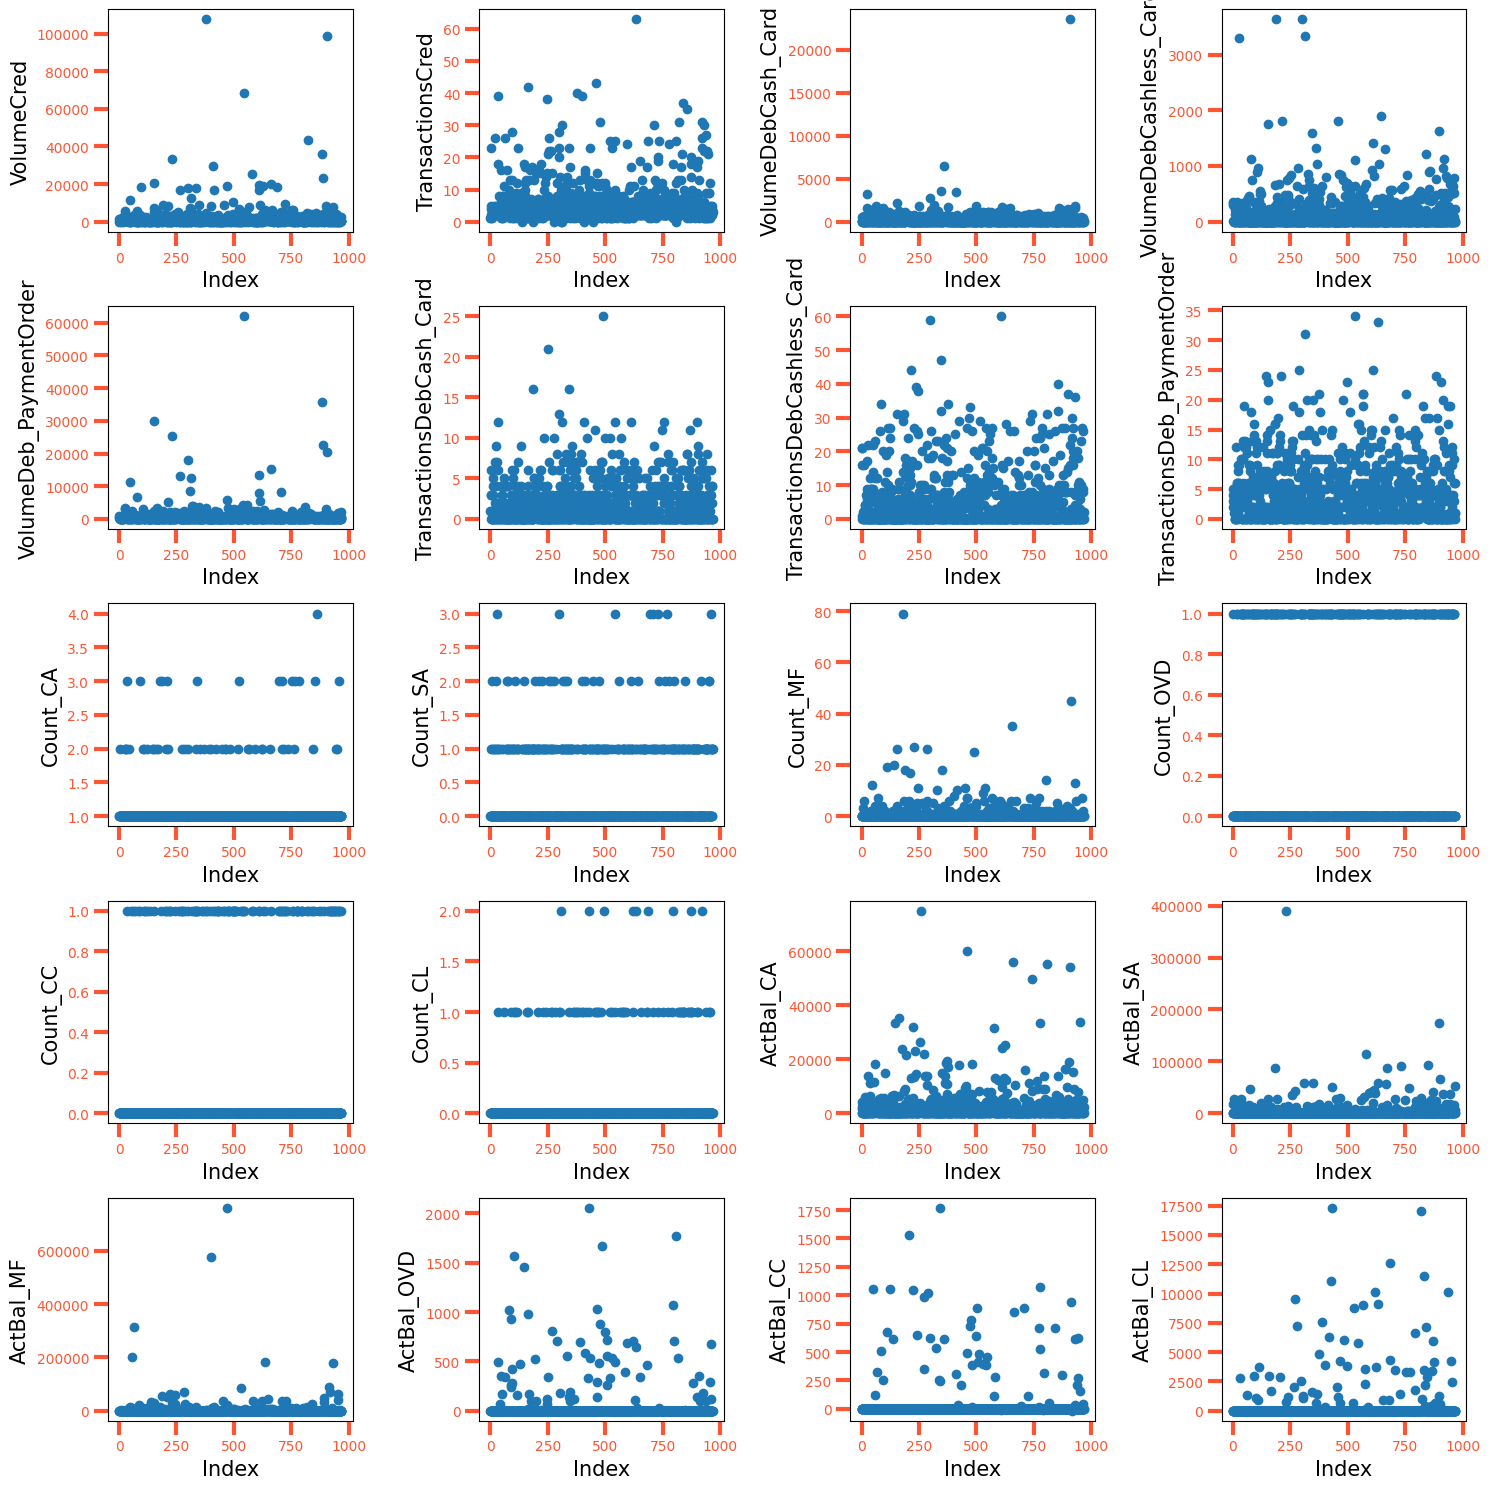

In [32]:
features_cols = ['VolumeCred', 'TransactionsCred', 'VolumeDebCash_Card',
       'VolumeDebCashless_Card', 'VolumeDeb_PaymentOrder',
       'TransactionsDebCash_Card', 'TransactionsDebCashless_Card',
       'TransactionsDeb_PaymentOrder', 'Count_CA', 'Count_SA', 'Count_MF',
       'Count_OVD', 'Count_CC', 'Count_CL', 'ActBal_CA', 'ActBal_SA',
       'ActBal_MF', 'ActBal_OVD', 'ActBal_CC', 'ActBal_CL']

# Set up the figure and axes
nrows, ncols = 5, 4
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15))
axes = axes.flatten()

# Plot each feature against the index
for i, feature in enumerate(features_cols):
    axes[i].scatter(df_merged.index, df_merged[feature])
    axes[i].set_xlabel('Index')
    axes[i].set_ylabel(feature)

plt.tight_layout()
plt.show()

From visual evaluation, columns **VolumeCred, TranscationCred, VolumeDebCash_Card,VolumeDebCashless_Card, VolumeDebPaymentOrder, CountMF, ActBal_CA, ActBal_SA, ActBal_MF** likely contain some outliers

In [33]:
from scipy import stats

# Define columns to check for outliers
feat_outliers = ['VolumeCred', 'TransactionsCred', 'VolumeDebCashless_Card', 'VolumeDebCash_Card', 'VolumeDeb_PaymentOrder',
                 'Count_MF', 'ActBal_CA', 'ActBal_SA', 'ActBal_MF']

# Function to detect outliers using Z-score
def detect_outliers_z_score(df, columns, threshold=3):
    outliers = {}
    for col in columns:
        z_scores = np.abs(stats.zscore(df[col].dropna()))
        outlier_indexes = df.index[df[col].notna()][z_scores > threshold].tolist()
        outliers[col] = outlier_indexes
    return outliers

# Detect outliers
outliers_features = detect_outliers_z_score(df_merged, feat_outliers, threshold=10)

# Combine all outlier indexes into a single set
all_outlier_indexes = set()
for indexes in outliers_features.values():
    all_outlier_indexes.update(indexes)

# Remove outliers from the DataFrame
df_merged = df_merged.drop(index=all_outlier_indexes)

In [34]:
outliers_features

{'VolumeCred': [377, 544, 906],
 'TransactionsCred': [],
 'VolumeDebCashless_Card': [190, 300],
 'VolumeDebCash_Card': [906],
 'VolumeDeb_PaymentOrder': [544, 884],
 'Count_MF': [179, 913],
 'ActBal_CA': [257],
 'ActBal_SA': [230],
 'ActBal_MF': [401, 469]}

In [35]:
df_merged.shape

(897, 30)

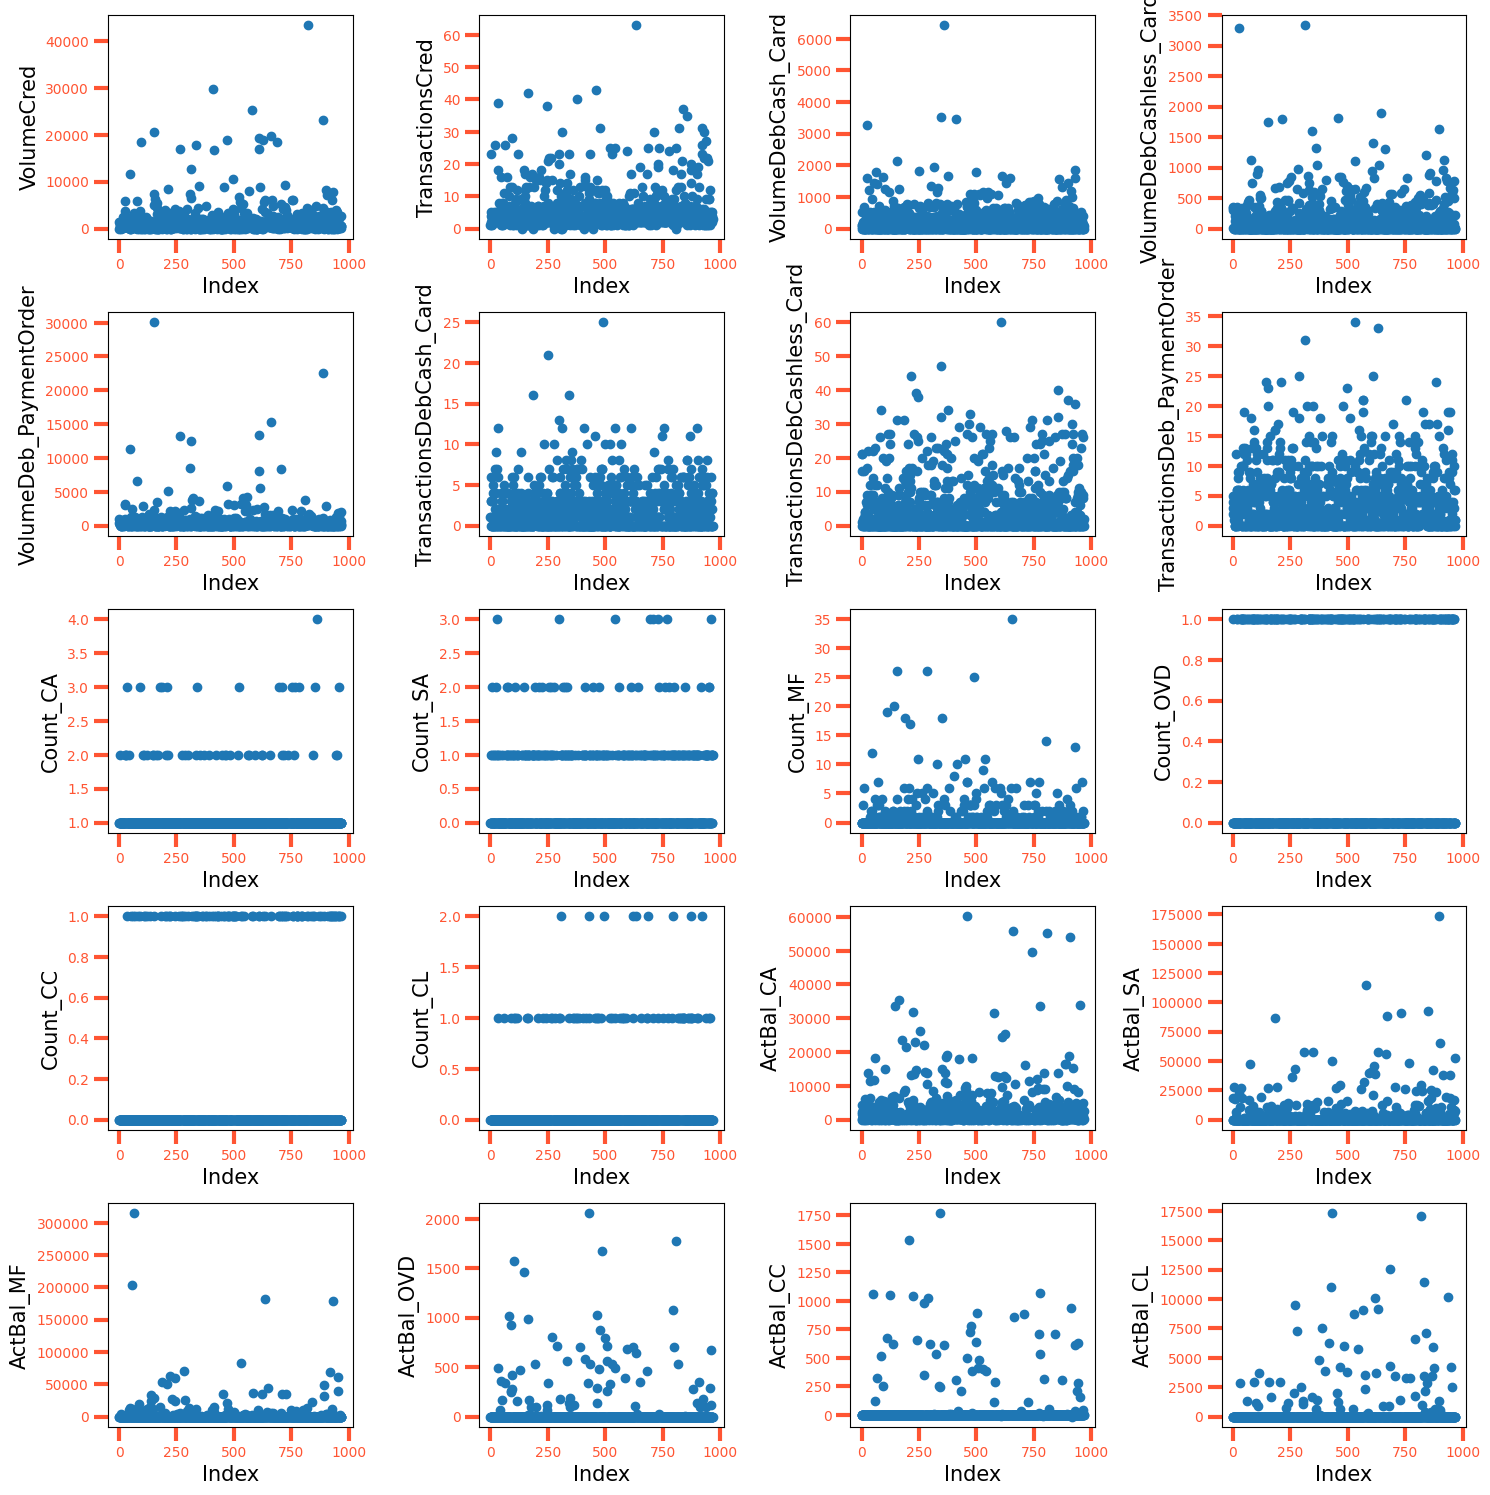

In [36]:
# Replot the features

nrows, ncols = 5, 4
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15))
axes = axes.flatten()

for i, feature in enumerate(features_cols):
    axes[i].scatter(df_merged.index, df_merged[feature])
    axes[i].set_xlabel('Index')
    axes[i].set_ylabel(feature)

plt.tight_layout()
plt.show()

<medium> **Checking for outliers in target** </medium>

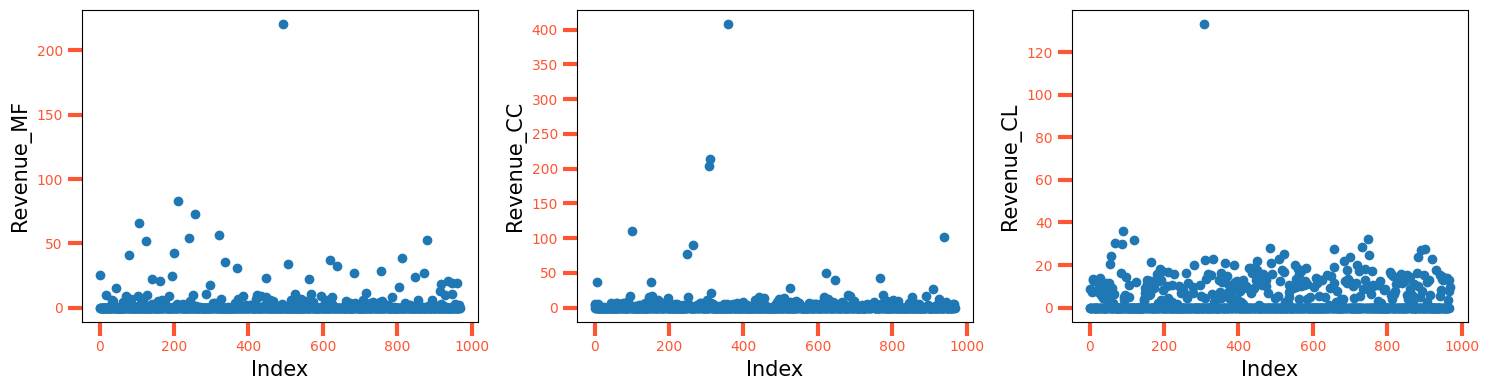

In [37]:
target_cols = ['Revenue_MF', 'Revenue_CC', 'Revenue_CL']

nrows, ncols = 1, 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 4))
axes = axes.flatten()

for i, feature in enumerate(target_cols):
    axes[i].scatter(df_merged.index, df_merged[feature])
    axes[i].set_xlabel('Index')
    axes[i].set_ylabel(feature)

plt.tight_layout()
plt.show()

In [38]:
# Detect outliers
outliers_target = detect_outliers_z_score(df_merged, target_cols, threshold=10)

# Combine all outlier indexes into a single set
all_outlier_indexes = set()
for indexes in outliers_target.values():
    all_outlier_indexes.update(indexes)

# Remove outliers from the DataFrame
df_merged = df_merged.drop(index=all_outlier_indexes)

In [39]:
outliers_target

{'Revenue_MF': [494], 'Revenue_CC': [307, 310, 359], 'Revenue_CL': [308]}

In [40]:
df_merged.shape

(892, 30)

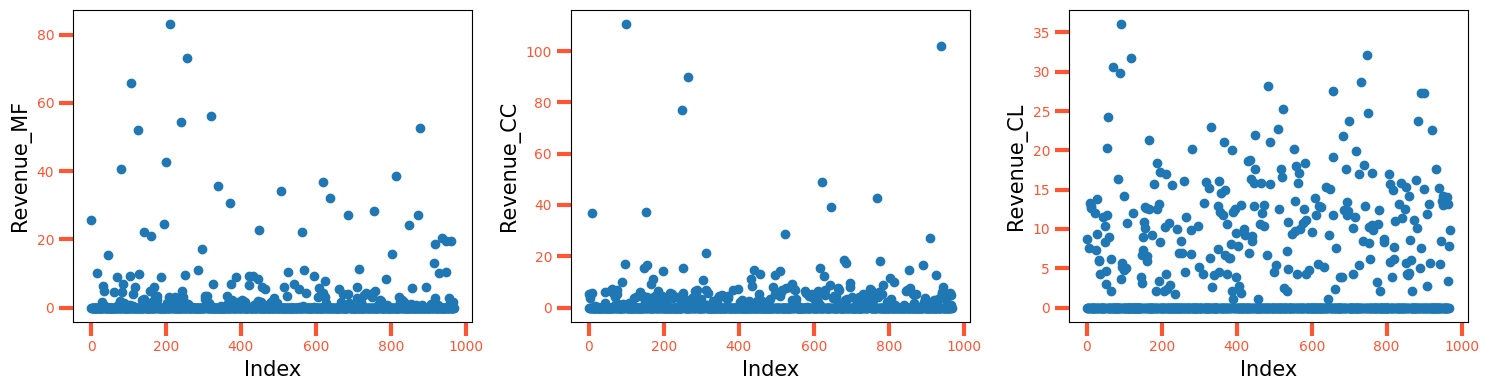

In [41]:
nrows, ncols = 1, 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 4))
axes = axes.flatten()

for i, feature in enumerate(target_cols):
    axes[i].scatter(df_merged.index, df_merged[feature])
    axes[i].set_xlabel('Index')
    axes[i].set_ylabel(feature)

plt.tight_layout()
plt.show()

<h3> EDA of customers </h3>

In [42]:
# Creating dataframes for customers that bought specific product

df_cl_customers = df_merged[df_merged['Sale_CL'] == 1]
df_cc_customers = df_merged[df_merged['Sale_CC'] == 1]
df_mf_customers = df_merged[df_merged['Sale_MF'] == 1]

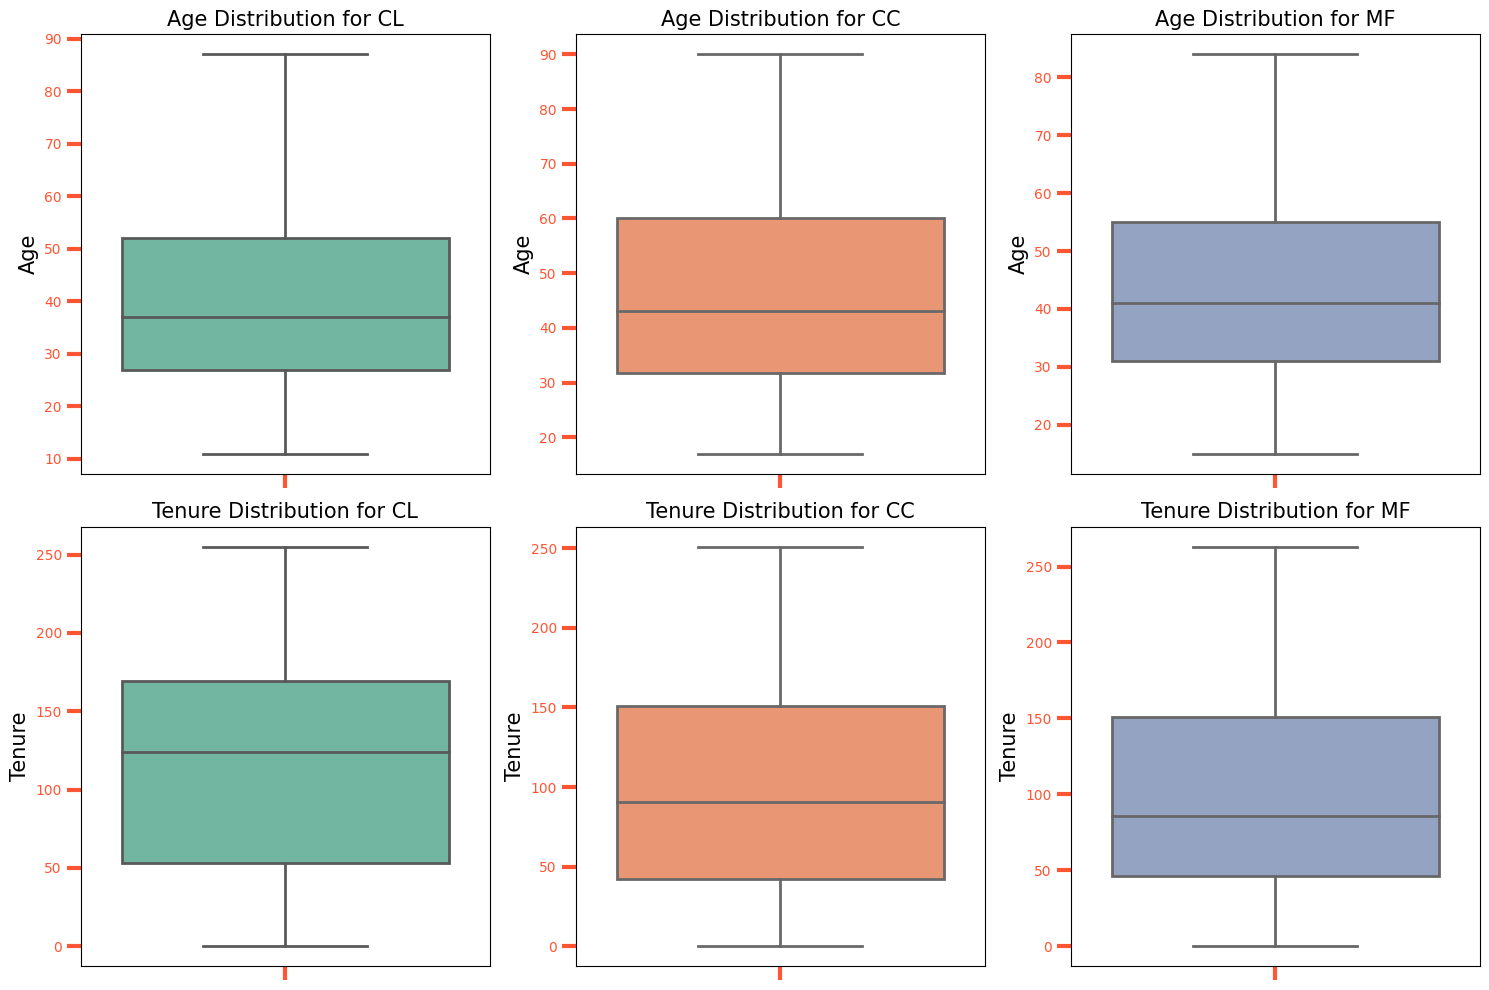

In [43]:
# Dictionary to map product names to their respective columns

products = {
    'CL': 'Sale_CL',
    'CC': 'Sale_CC',
    'MF': 'Sale_MF'}

# List of y values to plot
y_values = ['Age', 'Tenure']

# List of colors for the boxplots
colors = sns.color_palette("Set2", len(products))

# Create subplots
num_products = len(products)
num_y_values = len(y_values)
fig, axes = plt.subplots(nrows=num_y_values, ncols=num_products, figsize=(15, 5 * num_y_values))

# Loop through each y value and product to create boxplots
for i, y in enumerate(y_values):
    for j, (product, column) in enumerate(products.items()):
        df_customers = df_merged[df_merged[column] == 1]
        sns.boxplot(y=y, data=df_customers, ax=axes[i, j], color=colors[j])
        axes[i, j].set_title(f'{y} Distribution for {product}')
        axes[i, j].set_ylabel(y)

plt.tight_layout()
plt.show()

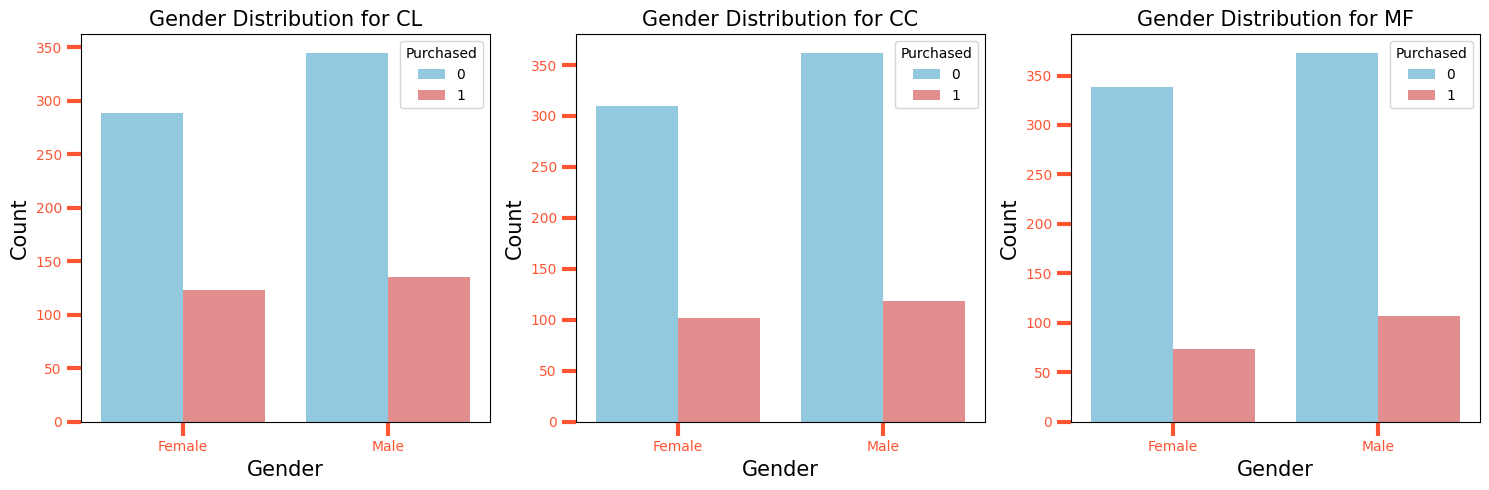

In [44]:
# Create subplots

fig, axes = plt.subplots(nrows=1, ncols=len(products), figsize=(15, 5))
palette = {0: 'skyblue', 1: 'lightcoral'}

# Loop through each product to create countplots
for i, (product_name, product_column) in enumerate(products.items()):
    sns.countplot(x='Sex', hue=product_column, data=df_merged, ax=axes[i], palette = palette)
    axes[i].set_title(f'Gender Distribution for {product_name}')
    axes[i].set_xlabel('Gender')
    axes[i].set_ylabel('Count')
    axes[i].set_xticklabels(['Female', 'Male'])
    axes[i].legend(title='Purchased', loc='upper right')

plt.tight_layout()
plt.show()

From visual evaluation, no significant difference in **Age/Gender** was found between the different products.\
However, a potential difference in **Tenure** was observed, which requires further evaluation.

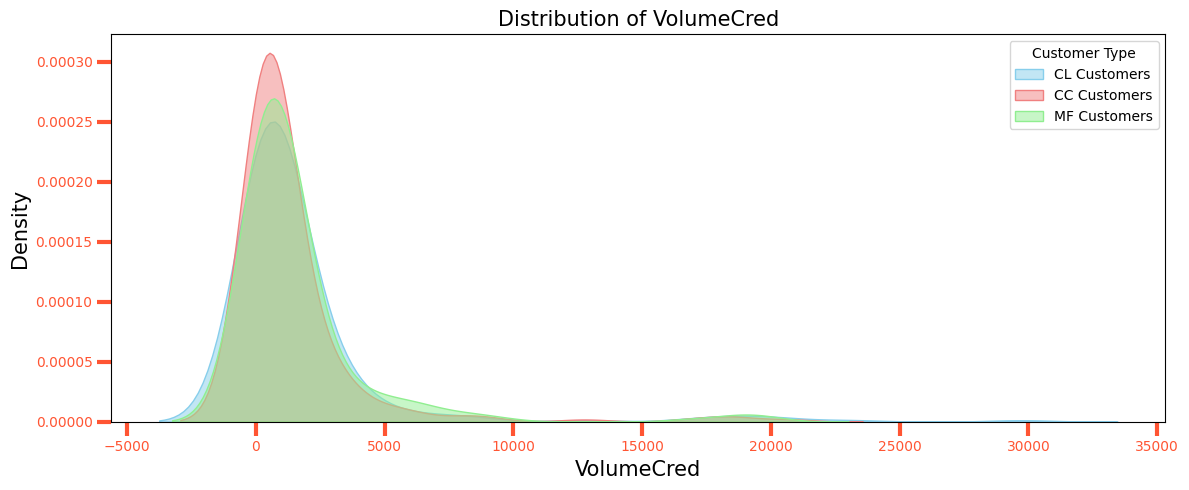

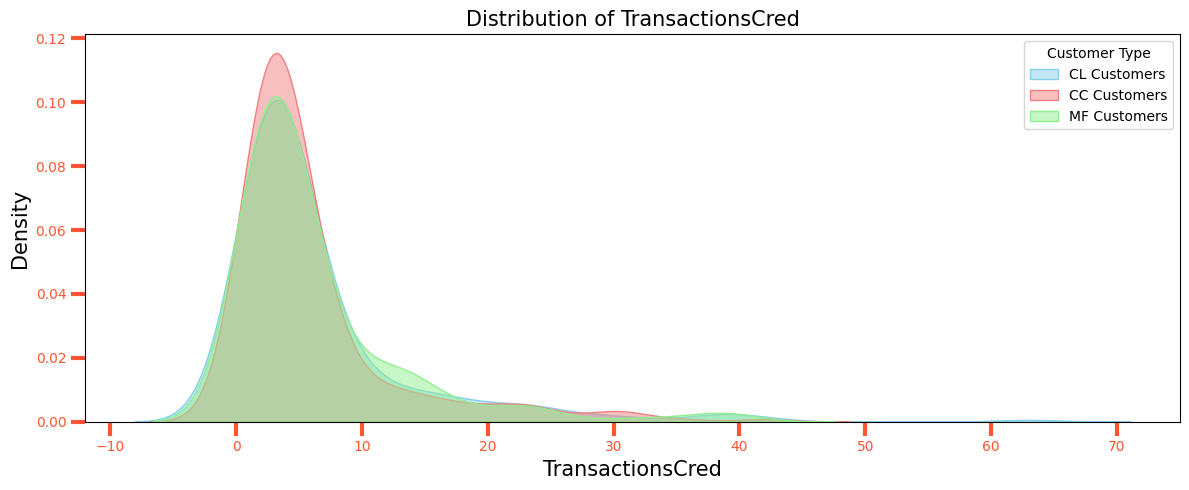

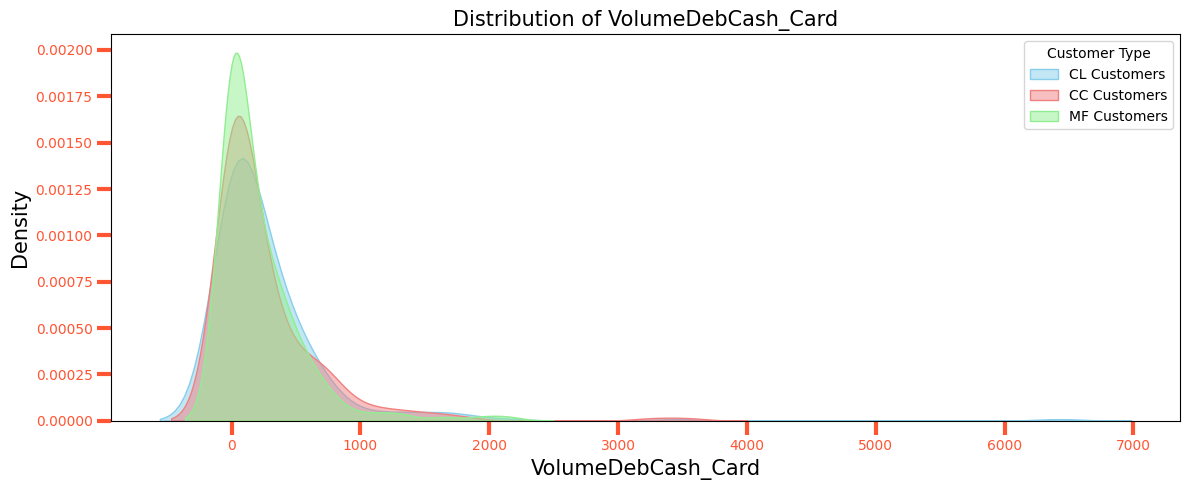

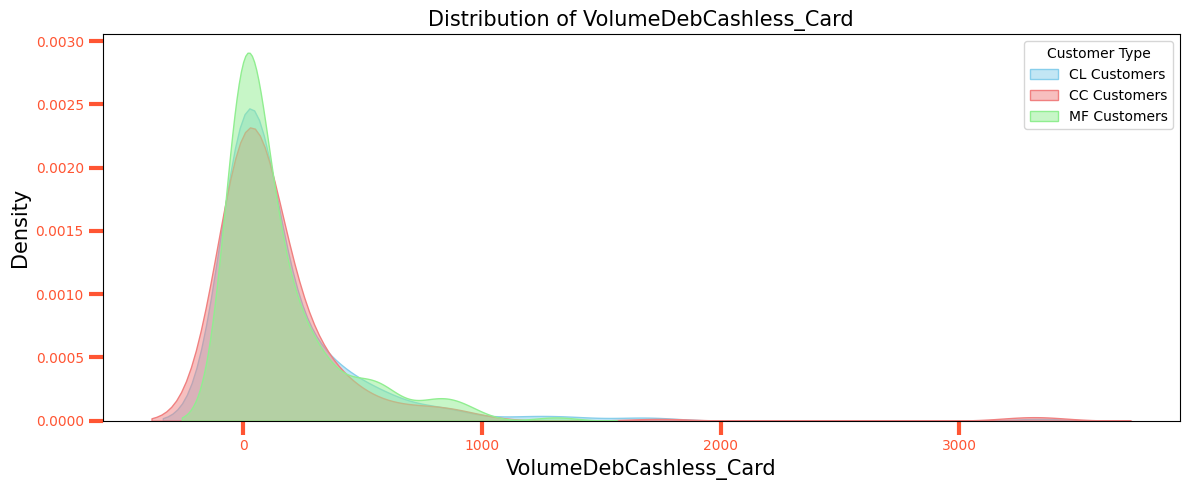

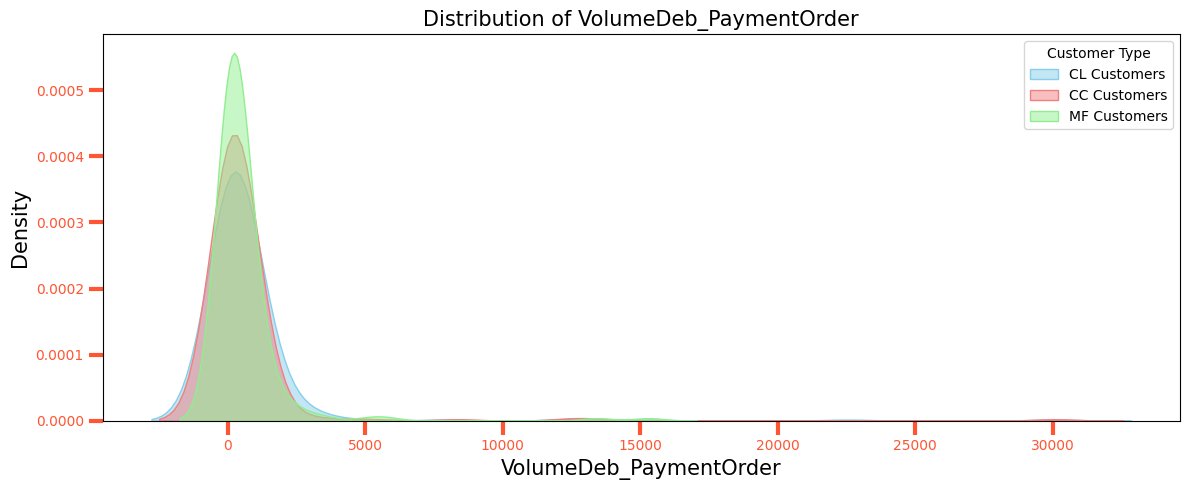

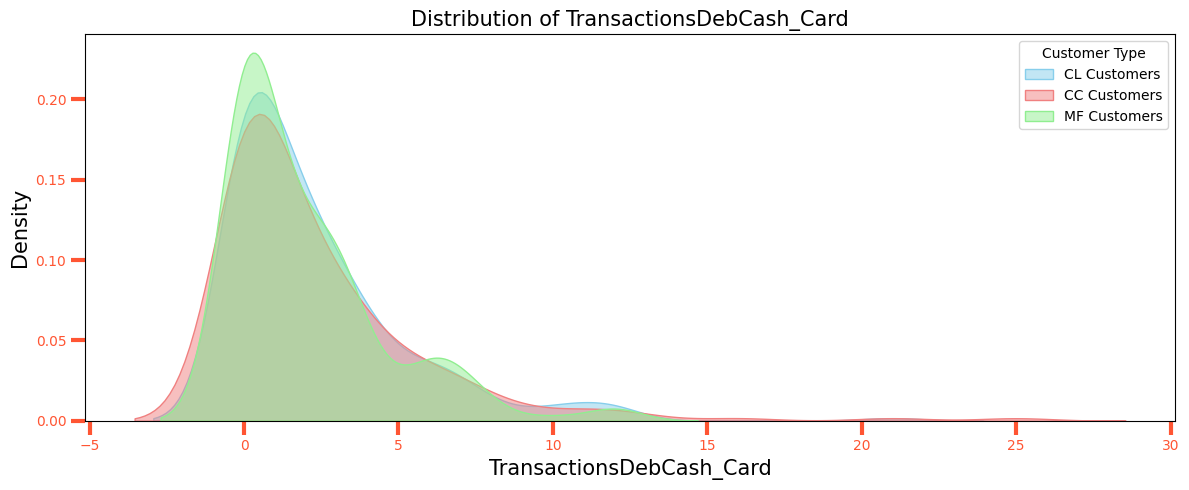

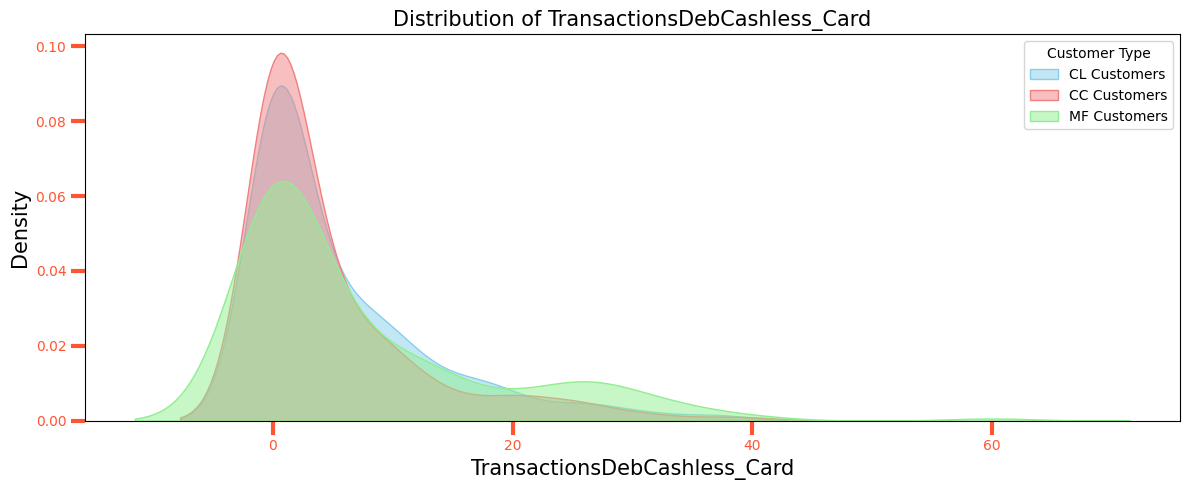

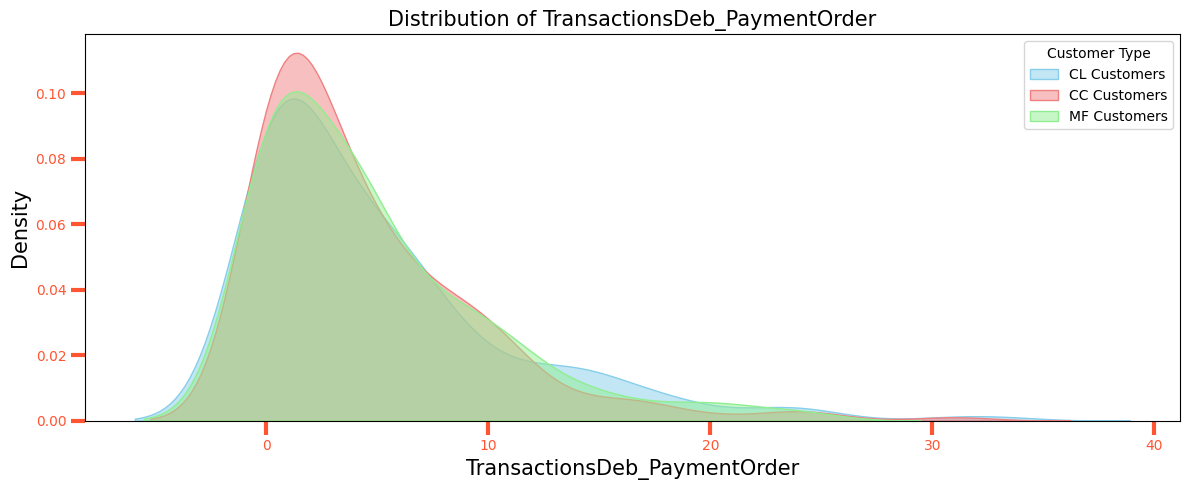

In [45]:
# Function to plot KDE plots for all customer groups

def plot_grouped_kde(dataframes, column, titles, colors):
    plt.figure(figsize=(12, 5))
    
    for df, title, color in zip(dataframes, titles, colors):
        if column in df.columns:
            sns.kdeplot(data=df[column], color=color, label=title, fill=True, alpha=0.5)
    
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Density')
    plt.legend(title='Customer Type')
    plt.tight_layout()
    plt.show()

# Prepare data for plotting
dataframes = [df_cl_customers, df_cc_customers, df_mf_customers]
titles = ['CL Customers', 'CC Customers', 'MF Customers']
colors = ['skyblue', 'lightcoral', 'lightgreen']

# Columns to plot
columns_to_plot = ['VolumeCred', 'TransactionsCred', 'VolumeDebCash_Card', 
        'VolumeDebCashless_Card', 'VolumeDeb_PaymentOrder',
       'TransactionsDebCash_Card', 'TransactionsDebCashless_Card',
       'TransactionsDeb_PaymentOrder']

# Generate KDE plot for each column
for column in columns_to_plot:
    plot_grouped_kde(dataframes, column, titles, colors)

<h2> Propensity models for different products </h2>

Preparing **KFold Stratified Cross-Validation** with **SMOTE** using **catboost** model with hyperparameter tuning.

In [46]:
from sklearn.metrics import precision_recall_curve, auc, make_scorer

def pr_auc_score(y_true, y_pred_proba):
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    return auc(recall, precision)

pr_auc = make_scorer(pr_auc_score, needs_proba=True)

In [47]:
selector = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

pipe_catboost = Pipelinesm([('smote', SMOTE(sampling_strategy=0.7, random_state=42)),
    ('catboost', CatBoostClassifier(verbose=0, random_seed=42))])

param_grid = {'catboost__n_estimators': [100, 500, 1000],
          'catboost__max_depth': [2, 3, 5, 10],
          'catboost__learning_rate': [0.1, 0.05, 0.01, 0.001]}

# Function to perform GridSearchCV
def perform_grid_search(X, Y):
    grid_search = GridSearchCV(estimator=pipe_catboost, param_grid=param_grid, 
                               scoring=pr_auc, cv=selector, n_jobs=-1, verbose=0)
    grid_search.fit(X, Y)
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    best_model = grid_search.best_estimator_
    
    return best_params, best_score, best_model

<h3>Consumer Loan</h3>

In [48]:
# Creating df for Consumer loan

df_cl = df_merged.drop(['Sale_MF', 'Sale_CC', 'Revenue_MF', 'Revenue_CC', 'Revenue_CL'], axis=1)

X_cl = df_cl.drop(['Client','Sale_CL'], axis=1)
Y_cl = df_cl['Sale_CL']

In [49]:
# Performing GridSearchCV

best_params_cl, best_score_cl, best_catboost_cl = perform_grid_search(X_cl, Y_cl)
print(f"Consumer Loan - Best Parameters: {best_params_cl}")
print(f"Consumer Loan - PR-AUC on Cross-Validation: {best_score_cl:.4f}")
print(f"Consumer Loan - PR-AUC of a Random Classifier: {sales['Sale_CL'][1]}")

Consumer Loan - Best Parameters: {'catboost__learning_rate': 0.01, 'catboost__max_depth': 3, 'catboost__n_estimators': 500}
Consumer Loan - PR-AUC on Cross-Validation: 0.4044
Consumer Loan - PR-AUC of a Random Classifier: 0.29


<h3> Credit Card </h3>

In [50]:
# Creating df for Credit Card

df_cc = df_merged.drop(['Sale_MF', 'Sale_CL', 'Revenue_MF', 'Revenue_CC', 'Revenue_CL'], axis=1)

X_cc = df_cc.drop(['Client','Sale_CC'], axis=1)
Y_cc = df_cc['Sale_CC']

In [51]:
# Performing GridSearchCV

best_params_cc, best_score_cc, best_catboost_cc = perform_grid_search(X_cc, Y_cc)
print(f"Credit Card - Best Parameters: {best_params_cc}")
print(f"Credit Card - PR-AUC on Cross-Validation: {best_score_cc:.4f}")
print(f"Credit Card - PR-AUC of a Random Classifier: {sales['Sale_CC'][1]}")

Credit Card - Best Parameters: {'catboost__learning_rate': 0.05, 'catboost__max_depth': 5, 'catboost__n_estimators': 100}
Credit Card - PR-AUC on Cross-Validation: 0.4214
Credit Card - PR-AUC of a Random Classifier: 0.25


<h3> Mutual Fund </h3>

In [52]:
# Creating df for Mutual Fund

df_mf = df_merged.drop(['Sale_CC', 'Sale_CL', 'Revenue_MF', 'Revenue_CC', 'Revenue_CL'], axis=1)

X_mf = df_mf.drop(['Client','Sale_MF'], axis=1)
Y_mf = df_mf['Sale_MF']

In [53]:
# Performing GridSearchCV

best_params_mf, best_score_mf, best_catboost_mf = perform_grid_search(X_mf, Y_mf)
print(f"Mutual Fund - Best Parameters: {best_params_mf}")
print(f"Mutual Fund - PR-AUC on Cross-Validation: {best_score_mf:.4f}")
print(f"Mutual Fund - PR-AUC of a Random Classifier: {sales['Sale_MF'][1]}")

Mutual Fund - Best Parameters: {'catboost__learning_rate': 0.05, 'catboost__max_depth': 5, 'catboost__n_estimators': 500}
Mutual Fund - PR-AUC on Cross-Validation: 0.3063
Mutual Fund - PR-AUC of a Random Classifier: 0.21


<h2> Prediction models for revenue </h2>

Preparing **KFold Cross-Validation** using **Lasso regression** with hyperparameter tuning.\
To show realistic error on the training set, the predictions close to 0 are set to 0.\
The training dataset was supplemented with the labeled sales data (0 or 1) as one of the features.

In [54]:
from sklearn.base import BaseEstimator, RegressorMixin

# Custom Wrapper to set predictions close to 0 as 0
class ZeroThresholdRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, base_model, threshold=0.1):
        self.base_model = base_model
        self.threshold = threshold
    
    def fit(self, X, y, **kwargs):
        self.base_model.fit(X, y, **kwargs)
        return self
    
    def predict(self, X):
        preds = self.base_model.predict(X)
        preds[preds < self.threshold] = 0
        return preds

In [55]:
# Define parameter grid
alphas = np.linspace(0.0001, 100, num=50)
param_grid = {'lasso__base_model__alpha': alphas}

# KFold
selector = KFold(n_splits=10, shuffle=True, random_state=42)

# Pipeline with scaling
pipe_lasso = Pipeline([('scaler', MinMaxScaler()),
                       ('lasso', ZeroThresholdRegressor(Lasso(max_iter=100000), threshold=0.5))])

# Function to perform GridSearchCV
def perform_grid_search_lasso(X, Y):
        
    cv_lasso = GridSearchCV(pipe_lasso, param_grid=param_grid, scoring='neg_mean_absolute_error', 
                            cv=selector, return_train_score=True, n_jobs=-1, verbose=0,)
    cv_lasso.fit(X, Y)
    best_params = cv_lasso.best_params_
    best_model = cv_lasso.best_estimator_
    
    train_preds = best_model.predict(X)
    mae_train = mean_absolute_error(Y, train_preds)
    
    return best_params, best_model, mae_train

<h3> Consumer Loan </h3>

In [56]:
# Creating dataset for training

df_merged_rev_cl = df_merged.drop(['Sale_MF', 'Sale_CC', 'Revenue_MF', 'Revenue_CC'], axis=1)
df_merged_rev_cl.drop(['Client'], axis=1, inplace=True)

X_cl_rev = df_merged_rev_cl.drop(['Revenue_CL'],axis=1)
Y_cl_rev = df_merged_rev_cl['Revenue_CL']

In [57]:
# Perform GridSearchCV

best_params_cl, best_lasso_cl, mae_train_cl = perform_grid_search_lasso(X_cl_rev, Y_cl_rev)
print(f"Consumer Loan - Best Parameters: {best_params_cl}")
print(f"Consumer Loan - MAE on Cross-Validation: {mae_train_cl:.3f}")

Consumer Loan - Best Parameters: {'lasso__base_model__alpha': 0.0001}
Consumer Loan - MAE on Cross-Validation: 1.532


In [58]:
print(f" MAE for Revenue_CL: {mae_train_cl:.3f}")
print(f" Mean for Revenue_CL: {np.mean(Y_cl_rev):.3f}")

 MAE for Revenue_CL: 1.532
 Mean for Revenue_CL: 3.269


<h3> Credit Card </h3>

In [59]:
# Creating dataset for training

df_merged_rev_cc = df_merged.drop(['Sale_MF', 'Sale_CL', 'Revenue_MF', 'Revenue_CL'], axis=1)
df_merged_rev_cc.drop(['Client'], axis=1, inplace=True)

X_cc_rev = df_merged_rev_cc.drop(['Revenue_CC'],axis=1)
Y_cc_rev = df_merged_rev_cc['Revenue_CC']

In [60]:
# Perform GridSearchCV

best_params_cc, best_lasso_cc, mae_train_cc = perform_grid_search_lasso(X_cc_rev, Y_cc_rev)
print(f"Credit Card - Best Parameters: {best_params_cc}")
print(f"Credit Card - MAE on Cross-Validation: {mae_train_cc:.3f}")

Credit Card - Best Parameters: {'lasso__base_model__alpha': 0.0001}
Credit Card - MAE on Cross-Validation: 1.811


In [61]:
print(f" MAE for Revenue_CL: {mae_train_cc:.3f}")
print(f" Mean for Revenue_CL: {np.mean(Y_cc_rev):.3f}")

 MAE for Revenue_CL: 1.811
 Mean for Revenue_CL: 1.913


<h3> Mutual Fund </h3>

In [62]:
# Creating dataset for training

df_merged_rev_mf = df_merged.drop(['Sale_CC', 'Sale_CL', 'Revenue_CC', 'Revenue_CL'], axis=1)
df_merged_rev_mf.drop(['Client'], axis=1, inplace=True)

X_mf_rev = df_merged_rev_mf.drop(['Revenue_MF'],axis=1)
Y_mf_rev = df_merged_rev_mf['Revenue_MF']

In [63]:
# Perform GridSearchCV
    
best_params_mf, best_lasso_mf, mae_train_mf = perform_grid_search_lasso(X_mf_rev, Y_mf_rev)
print(f"Mutual Fund - Best Parameters: {best_params_mf}")
print(f"Mutual Fund - MAE on Cross-Validation: {mae_train_mf:.3f}")

Mutual Fund - Best Parameters: {'lasso__base_model__alpha': 0.0001}
Mutual Fund - MAE on Cross-Validation: 2.057


In [64]:
print(f" MAE for Revenue_CL: {mae_train_mf:.3f}")
print(f" Mean for Revenue_CL: {np.mean(Y_mf_rev):.3f}")

 MAE for Revenue_CL: 2.057
 Mean for Revenue_CL: 1.797


<h3> Predicting best offer and estimated revenue </h3>

Creating dataset of clients that were not yet contacted.

In [65]:
df_merged_fin = pd.merge(df3, df2, on='Client', how='left')
df_merged_fin = pd.merge(df_merged_fin, df1, on='Client', how='left')

filtered_clients = df_merged_fin[~df_merged_fin['Client'].isin(df4['Client'])]

In [66]:
# Function to predict sales probability and estimated revenue

def predict_revenue(clients, product_model, revenue_model, product):
    df_merged = clients.copy()
    df_merged.drop('Client', axis=1, inplace=True)
    
    sales_col = f'Sale_{product}'
    revenue_pred_col = f'Revenue_{product}_Pred'
    estimated_revenue_col = f'Estimated_Revenue_{product}'
    
    # Predict sales probability
    df_merged[sales_col] = product_model.predict_proba(df_merged)[:, 1]
    
    # Ensure the columns are in the same order as during training
    columns_order = [sales_col] + [col for col in df_merged.columns if col != sales_col]
    df_merged = df_merged[columns_order]
    
    # Predict revenue
    df_merged[revenue_pred_col] = revenue_model.predict(df_merged)
    
    # Calculate estimated revenue
    df_merged[estimated_revenue_col] = df_merged[revenue_pred_col] * df_merged[sales_col]
    
    return df_merged

In [67]:
# Predict for Consumer Loan, Credit Card, Mutual Fund

df_merged_cl = predict_revenue(filtered_clients, best_catboost_cl, best_lasso_cl, 'CL')
df_merged_cc = predict_revenue(filtered_clients, best_catboost_cc, best_lasso_cc, 'CC')
df_merged_mf = predict_revenue(filtered_clients, best_catboost_mf, best_lasso_mf, 'MF')

In [68]:
# Function to get the largest and second largest values

def get_largest_values(row):
    
    values = row[1:].tolist()  # Convert to list excluding first column 'Client'
    largest = np.partition(values, -2)[-2:]  # Get the two largest
    return pd.Series({'Largest': largest[-1], 'Second_Largest': largest[-2]})

For further analysis, the revenue from the best product (**Largest_Revenue**), the second best product (**Second_Largest_Revenue**), and the total revenue (**Total_Revenue**) were calculated. The best offer (**Best_Offer**) was chosen as the product that brought the highest estimated revenue. \
Finally, the obtained dataset was filtered by **Total_Revenue**, and the top 15% of customers were selected. It was decided to sort the dataset based on **Total_Revenue** instead of **Largest_Revenue**, assuming that some customers are willing to buy multiple products and may bring higher overall revenues.

In [69]:
# Creating df for client selection

df_revenues = pd.concat([filtered_clients['Client'], 
                         df_merged_cl['Estimated_Revenue_CL'], 
                         df_merged_cc['Estimated_Revenue_CC'], 
                         df_merged_mf['Estimated_Revenue_MF']
                        ], axis=1)

# Estimated revenue by selling the best or two best products
df_revenues[['Largest_Revenue', 'Second_Largest_Revenue']] = df_revenues.apply(get_largest_values, axis=1)
df_revenues['Best_offer'] = df_revenues[['Estimated_Revenue_CL', 'Estimated_Revenue_CC', 
                                          'Estimated_Revenue_MF']].idxmax(axis=1)

# Define the mapping dictionary

column_name_mapping = {
    'Estimated_Revenue_CC': 'Credit Card',
    'Estimated_Revenue_CL': 'Consumer Loan',
    'Estimated_Revenue_MF': 'Mutual Fund'}

# Remap the column names
df_revenues['Best_offer'] = df_revenues['Best_offer'].map(column_name_mapping)

# Calculate the Total Estimated Revenue
df_revenues['Total_Revenue'] = (df_revenues['Estimated_Revenue_CL'] + df_revenues['Estimated_Revenue_CC'] 
                                + df_revenues['Estimated_Revenue_MF'])

In [70]:
# Sorting by estimated revenue and selecting 15%

df_revenues.sort_values('Total_Revenue', ascending=False, inplace=True)
customers_to_contact = df_revenues.head(int(df_revenues.shape[0] * 0.15))

# Calculating estimated revenue
EV_one = customers_to_contact['Largest_Revenue'].sum()
EV_two = customers_to_contact['Largest_Revenue'].sum() + customers_to_contact['Second_Largest_Revenue'].sum()
EV_three = customers_to_contact['Total_Revenue'].sum()

print(f'Estimated revenue from targeting with one best product: {EV_one.round(2)}')
print(f'Estimated revenue from targeting with two bests products: {EV_two.round(2)}')
print(f'Estimated revenue from targeting with three products: {EV_three.round(2)}')

Estimated revenue from targeting with one best product: 357.19
Estimated revenue from targeting with two bests products: 531.62
Estimated revenue from targeting with three products: 591.11


In [71]:
# Customers to contact with which offer

customers_to_contact = customers_to_contact[['Client', 'Best_offer']]
customers_to_contact.to_csv('Customers_to_contact.csv', index=False)

<h3> Comparing with a random strategy for contacting clients </h3>

<medium> **Clients chosen by the model** </medium>

In [72]:
# Comparing with random contacting of clients

tested_clients = df_merged_fin[df_merged_fin['Client'].isin(df4['Client'])]

# Predictions
df_test_cl = predict_revenue(tested_clients, best_catboost_cl, best_lasso_cl, 'CL')
df_test_cc = predict_revenue(tested_clients, best_catboost_cc, best_lasso_cc, 'CC')
df_test_mf = predict_revenue(tested_clients, best_catboost_mf, best_lasso_mf, 'MF')

# Creating df for client selection
df_revenue_test = pd.concat([tested_clients['Client'], 
                         df_test_cl['Estimated_Revenue_CL'], 
                         df_test_cc['Estimated_Revenue_CC'], 
                         df_test_mf['Estimated_Revenue_MF']
                        ], axis=1)

# Estimated revenue by selling the best or two best products
df_revenue_test[['Largest_Revenue', 'Second_Largest_Revenue']] = df_revenue_test.apply(get_largest_values, axis=1)
df_revenue_test['Best_offer'] = df_revenue_test[['Estimated_Revenue_CL', 'Estimated_Revenue_CC', 
                                          'Estimated_Revenue_MF']].idxmax(axis=1)

# Define the mapping dictionary

column_name_mapping = {
    'Estimated_Revenue_CC': 'Credit Card',
    'Estimated_Revenue_CL': 'Consumer Loan',
    'Estimated_Revenue_MF': 'Mutual Fund'}

# Remap the column names
df_revenue_test['Best_offer'] = df_revenue_test['Best_offer'].map(column_name_mapping)

# Calculate the Total Estimated Revenue
df_revenue_test['Total_Revenue'] = (df_revenue_test['Estimated_Revenue_CL'] + df_revenue_test['Estimated_Revenue_CC'] 
                                + df_revenue_test['Estimated_Revenue_MF'])

In [73]:
# Sorting by estimated revenue and selecting 15%
df_revenue_test.sort_values('Total_Revenue', ascending=False, inplace=True)
customers_to_contact_test = df_revenue_test.head(int(df_revenue_test.shape[0] * 0.15))

# Calculating estimated revenue
EV_one_test = customers_to_contact_test['Largest_Revenue'].sum()

In [74]:
# Creatind df with the same customers with known revenues

selected_customers = customers_to_contact_test.Client.tolist()
selected_customers_data = df4[df4['Client'].isin(selected_customers)].copy()

In [75]:
# Calculate the maximum revenue and assign it to a new column
selected_customers_data['Largest_Revenue'] = selected_customers_data[['Revenue_MF', 'Revenue_CC', 'Revenue_CL']].max(axis=1)
selected_customers_data['Total_Revenue'] = (selected_customers_data['Revenue_MF'] + selected_customers_data['Revenue_CC'] 
                                + selected_customers_data['Revenue_CL'])

EV_real_one_test = selected_customers_data['Largest_Revenue'].sum()
EV_real_three_test = selected_customers_data['Total_Revenue'].sum()

print(f'Estimated revenue from targeting with one best product: {EV_one_test.round(2)}')
print(f'Real revenue from targeting with one best product: {EV_real_one_test.round(2)}')

Estimated revenue from targeting with one best product: 863.72
Real revenue from targeting with one best product: 1728.82


<medium> **Randomly chosen clients** </medium>

In [76]:
# Example. Sampling with replacement

n_size = int(tested_clients.shape[0] * 0.15)
random_sample = df4.sample(n=n_size, replace=True, random_state=42)

In [77]:
# Calculate the maximum revenue and assign it to a new column

random_sample['Largest_Revenue'] = random_sample[['Revenue_MF', 'Revenue_CC', 'Revenue_CL']].max(axis=1)

EV_real_one_random = random_sample['Largest_Revenue'].sum()

print(f'Real revenue from random targeting with one best product: {EV_real_one_random.round(2)}')

Real revenue from random targeting with one best product: 951.91


In [78]:
# Testing

counter = 0
values = []  

for i in np.arange(0, 10000):
    
    random_sample = df4.sample(n=n_size, replace=True)
    random_sample['Largest_Revenue'] = random_sample[['Revenue_MF', 'Revenue_CC', 'Revenue_CL']].max(axis=1)
    EV_real_one_random = random_sample['Largest_Revenue'].sum()
    
    values.append(EV_real_one_random)
    
    if EV_real_one_test > EV_real_one_random:
        counter += 1

print(f'The model selects clients that generate higher revenue compared to random selection in {counter}/10000 cases.')

The model selects clients that generate higher revenue compared to random selection in 9838/10000 cases.


<medium> **Analysis of propensity models** </medium>

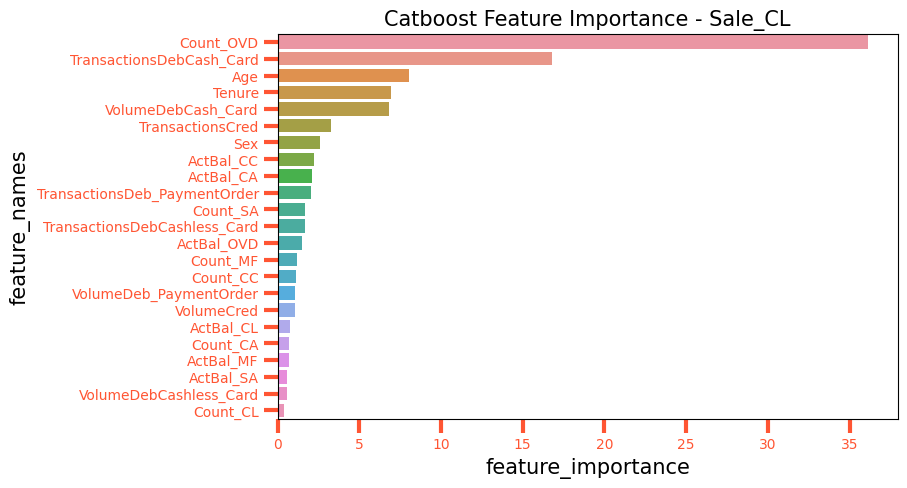

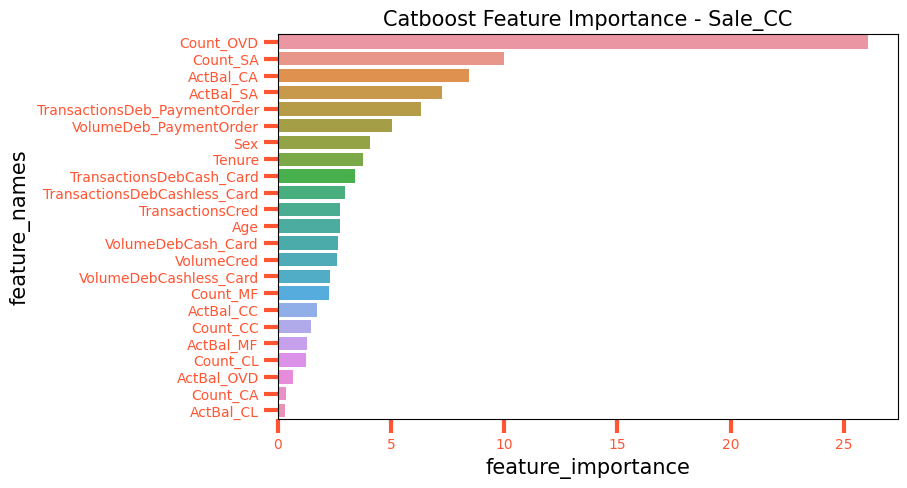

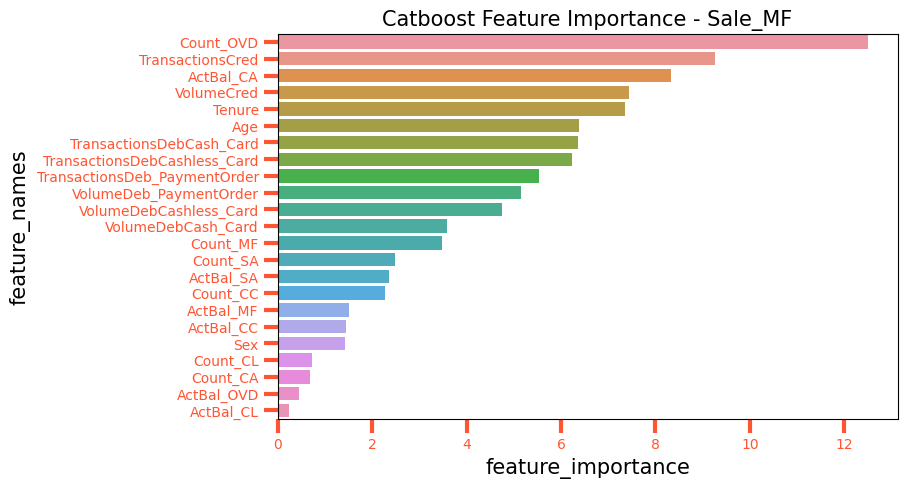

In [79]:
def plot_feature_importance(df, model, title):
    fi_df = pd.DataFrame({
        'feature_names': df.columns.drop(['Client', title.split()[-1]]),
        'feature_importance': model.get_feature_importance()
    })
    
    plt.figure(figsize=(8, 5))
    sns.barplot(x='feature_importance', y='feature_names', 
                data=fi_df.sort_values('feature_importance', ascending=False))
    plt.title(f'Catboost Feature Importance - {title}')
    plt.show()

# Plot feature importance for each model
plot_feature_importance(df_cl, best_catboost_cl.named_steps['catboost'], 'Sale_CL')
plot_feature_importance(df_cc, best_catboost_cc.named_steps['catboost'], 'Sale_CC')
plot_feature_importance(df_mf, best_catboost_mf.named_steps['catboost'], 'Sale_MF')

**To be considered:**\
Performing statistical tests (e.g. non-parametric) for the features with the highest importance retrieved from Catboost classifiers. For example, comparing the features between clients who bought product A and those who didn’t buy product A. In this case, p-value correction methods (like Bonferroni or Holm) should be used to control for family-wise error when performing multiple comparisons.

<medium> **Investigating the conditional probabilities of buying specific products.** </medium> \
For instance, clients who buy product A may have a higher probability of also buying product B, especially if the products are related.

In [80]:
# Total number of clients
total_clients = len(df_merged)

# Define a function to calculate conditional probabilities
def calculate_conditional_probability(df, cond_product, target_product):
    # Clients who bought the target product and the condition product
    both_bought = len(df[(df[cond_product] == 1) & (df[target_product] == 1)])
    
    # Clients who bought the condition product
    bought_cond = len(df[df[cond_product] == 1])
    
    # Conditional probability
    return both_bought / bought_cond if bought_cond > 0 else 0

# Calculate all required probabilities
prob_A_given_B = calculate_conditional_probability(df_merged, 'Sale_CL', 'Sale_CC')
prob_A_given_C = calculate_conditional_probability(df_merged, 'Sale_MF', 'Sale_CC')
prob_B_given_A = calculate_conditional_probability(df_merged, 'Sale_CC', 'Sale_CL')
prob_B_given_C = calculate_conditional_probability(df_merged, 'Sale_MF', 'Sale_CL')
prob_C_given_A = calculate_conditional_probability(df_merged, 'Sale_CC', 'Sale_MF')
prob_C_given_B = calculate_conditional_probability(df_merged, 'Sale_CL', 'Sale_MF')
prob_A_given_A, prob_B_given_B, prob_C_given_C = 1, 1, 1

# Create the 3x3 matrix of conditional probabilities
prob_matrix = pd.DataFrame({
    'P(A|B)': [prob_A_given_A, prob_B_given_A, prob_C_given_A],
    'P(A|C)': [prob_A_given_B, prob_B_given_B, prob_C_given_B],
    'P(B|C)': [prob_A_given_C, prob_B_given_C, prob_C_given_C]
}, index=['Product A', 'Product B', 'Product C'])

print(prob_matrix.round(2))

           P(A|B)  P(A|C)  P(B|C)
Product A    1.00    0.24    0.23
Product B    0.28    1.00    0.27
Product C    0.19    0.19    1.00
